In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Flower Dataset

In [ ]:
file_path = ''
data_test = np.load(f'{file_path}data_test.npy').T/255.0
labels_test = np.load(f'{file_path}labels_test.npy').astype(int)
data_test.shape, labels_test.shape

((415, 270000), (415,))

In [ ]:
X_dim, Y_dim = 300,300
X_test = tf.constant(data_test.reshape((data_test.shape[0],X_dim,Y_dim,3)), 
                         dtype=tf.float32)

X_test.shape

TensorShape([415, 300, 300, 3])

In [ ]:
class_names = ['Roses', 'Magnolias', 'Lilies', 'Sunflowers', 'Orchids', 'Marigold', 
               'Hibiscus', 'Firebush', 'Pentas', 'Bougainvillea']

In [ ]:
model = keras.models.load_model(f'{file_path}flower_model.h5')

In [ ]:
model.evaluate(X_test, labels_test)

13/13 [==============================] - 34s 3s/step - loss: 0.5053 - accuracy: 0.8602


[0.5052503943443298, 0.8602409362792969]

In [ ]:
y_test = np.argmax(model.predict(X_test),axis=1)

y_test.shape

13/13 [==============================] - 43s 3s/step


(415,)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels_test, y_test, target_names=class_names))

               precision    recall  f1-score   support

        Roses       0.78      0.79      0.78        48
    Magnolias       0.95      0.93      0.94        44
       Lilies       0.74      0.76      0.75        46
   Sunflowers       1.00      0.92      0.96        36
      Orchids       0.86      0.82      0.84        45
     Marigold       0.91      0.97      0.94        40
     Hibiscus       0.85      0.91      0.88        43
     Firebush       0.89      0.92      0.91        37
       Pentas       0.97      0.91      0.94        32
Bougainvillea       0.74      0.73      0.74        44

     accuracy                           0.86       415
    macro avg       0.87      0.87      0.87       415
 weighted avg       0.86      0.86      0.86       415



## Car dataset

In [3]:
import os
import cv2
from PIL import Image
import pandas as pd

In [4]:
file_path = f'/content/drive/MyDrive/Project3/'
images = os.listdir(f'{file_path}testing_images/')
print(len(images))

175


In [5]:
# Create a numpy array with all images

i=0
zero_count = 0
for filename in os.listdir(f'{file_path}testing_images/'): 
    image = np.array(Image.open(f'{file_path}testing_images/'+filename))
    image_col = image.ravel()[:,np.newaxis] 
    if i==0:
        X_test = image_col
        i=1
    else:
        X_test = np.hstack((X_test, image_col))

# Training feature matrices
X_test = X_test.T/255
X_test.shape

(175, 770640)

In [6]:
# size of each RGB image
(Nx,Ny,Nz) = (380, 676, 3) # image.shape

Nx, Ny, Nz

(380, 676, 3)

In [7]:
X_dim, Y_dim = Nx, Ny

X_test = X_test.reshape((X_test.shape[0],Nx,Ny,3))
  
X_test.shape

(175, 380, 676, 3)

In [8]:
model = keras.models.load_model(f'{file_path}car_model.h5')

In [9]:
test_labels = pd.read_csv(f'{file_path}test_labels.csv')
test_labels

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,car,333,187,60,21,vid_5_400.jpg,676,380
1,car,312,187,57,22,vid_5_420.jpg,676,380
2,car,289,188,57,21,vid_5_440.jpg,676,380


In [10]:
y_test = model.predict(X_test)

y_test.shape

6/6 [==============================] - 173s 28s/step


(175, 4)

In [16]:
idx = 20
print(images[idx],np.array(y_test[idx], dtype=np.uint8))
print((int(y_test[idx,0]), int(y_test[idx,1])), 
              (int(y_test[idx,2]), int(y_test[idx,3])))
x = np.array(X_test[idx])
y = np.array(y_test[idx]).astype(int)
# found = np.array(found)
# boxes = cv2.groupRectangles(found.tolist(), 1, 2)

vid_5_27740.jpg [0 0 0 0]
(0, 0) (0, 0)


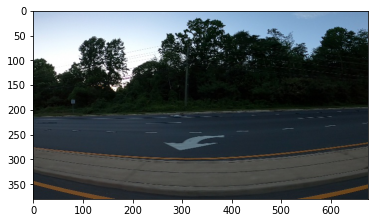

In [18]:
plt.imshow(x)
cv2.rectangle(x, (y[0], y[1]), 
                (y[2], y[3]), 
                (255, 0, 0), 2);

In [25]:
def val_metric(y_rect, t_rect):
  dx = min(y_rect[2], t_rect[2]) - max(y_rect[0], t_rect[0])
  dy = min(y_rect[3], t_rect[3]) - max(y_rect[1], t_rect[1])
  if (dx>=0) and (dy>=0):
    y_a = (y_rect[2]-y_rect[0]) * (y_rect[3]-y_rect[1])
    t_a = (t_rect[2]-t_rect[0]) * (t_rect[3]-t_rect[1])
    return dx*dy/(y_a + t_a - dx*dy)
  return 0

In [19]:
# predict bounding boxes for test images with labels created in MakeSenseAI
pred_images = []
for index, row in test_labels.iterrows():
    idx = images.index(row['image_name'])
    pred_images.append(X_test[idx])
print(np.array(pred_images).shape)
y_val = model.predict(np.array(pred_images))
y_val.shape

(3, 380, 676, 3)
1/1 [==============================] - 4s 4s/step


(3, 4)

[  0 177 354 219]
[333 187 393 208]
0.028112449799196786


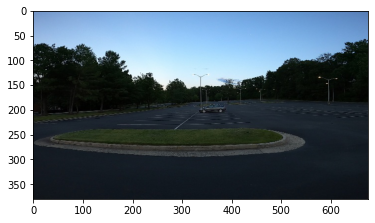

In [26]:
idx=0
x = np.array(pred_images[idx])
y = np.array(y_val[idx]).astype(int)
t = np.array([test_labels.iloc[idx]['bbox_x'],test_labels.iloc[idx]['bbox_y'],
              test_labels.iloc[idx]['bbox_x'] + test_labels.iloc[idx]['bbox_width'],
             test_labels.iloc[idx]['bbox_y'] + test_labels.iloc[idx]['bbox_height']]).astype(int)

print(y)
print(t)
print(val_metric(y,t))
plt.imshow(x)
cv2.rectangle(x, (y[0], y[1]), 
              (y[2], y[3]), 
              (255, 0, 0), 2);
cv2.rectangle(x, (t[0], t[1]), 
              (t[2], t[3]), 
              (0, 255, 0), 2);

[  0 178 315 218]
[312 187 369 209]
0.004786771105308964


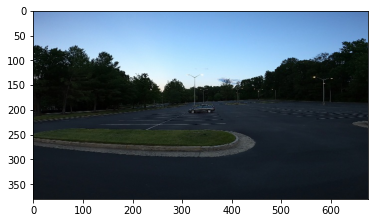

In [27]:
idx=1
x = np.array(pred_images[idx])
y = np.array(y_val[idx]).astype(int)
t = np.array([test_labels.iloc[idx]['bbox_x'],test_labels.iloc[idx]['bbox_y'],
              test_labels.iloc[idx]['bbox_x'] + test_labels.iloc[idx]['bbox_width'],
             test_labels.iloc[idx]['bbox_y'] + test_labels.iloc[idx]['bbox_height']]).astype(int)

print(y)
print(t)
print(val_metric(y,t))
plt.imshow(x)
cv2.rectangle(x, (y[0], y[1]), 
              (y[2], y[3]), 
              (255, 0, 0), 2);
cv2.rectangle(x, (t[0], t[1]), 
              (t[2], t[3]), 
              (0, 255, 0), 2);

[  0 173 231 212]
[289 188 346 209]
0


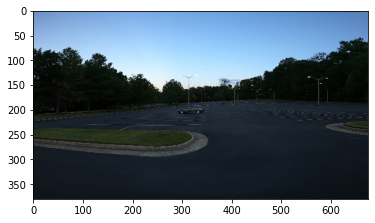

In [28]:
idx=2
x = np.array(pred_images[idx])
y = np.array(y_val[idx]).astype(int)
t = np.array([test_labels.iloc[idx]['bbox_x'],test_labels.iloc[idx]['bbox_y'],
              test_labels.iloc[idx]['bbox_x'] + test_labels.iloc[idx]['bbox_width'],
             test_labels.iloc[idx]['bbox_y'] + test_labels.iloc[idx]['bbox_height']]).astype(int)

print(y)
print(t)
print(val_metric(y,t))
plt.imshow(x)
cv2.rectangle(x, (y[0], y[1]), 
              (y[2], y[3]), 
              (255, 0, 0), 2);
cv2.rectangle(x, (t[0], t[1]), 
              (t[2], t[3]), 
              (0, 255, 0), 2);